In [1]:
import pandas as pd
import librosa
from scipy.io import wavfile
from python_speech_features import mfcc

## Load data

In [2]:
import os
selected_data = ["makan_suap", "others"]

# Get all audio path and label, then store it into pandas dataframe
def get_audio_path_and_label(dataset_path, selected_data):
    audio_path = []
    labels = []
    for label in selected_data:
        path = dataset_path + label
        for filename in os.listdir(path):
            audio_path.append(path + '/' + filename)
            labels.append(label)
    
    df = pd.DataFrame({'path': audio_path, 'label': labels})
    return df

df = get_audio_path_and_label('./audio/', selected_data)
df

,path,label
0,./audio/makan_suap/Makan Nara Rayhan 01.wav,makan_suap
1,./audio/makan_suap/Makan Nara Rayhan 02.wav,makan_suap
2,./audio/makan_suap/Makan Nara Rayhan 03.wav,makan_suap
3,./audio/makan_suap/Makan Nara Rayhan 04.wav,makan_suap
4,./audio/makan_suap/Makan Nara Rayhan 05.wav,makan_suap
...,...,...
414,./audio/others/pineapple14.wav,others
415,./audio/others/pineapple15.wav,others
416,./audio/others/pink_noise.wav,others
417,./audio/others/running_tap.wav,others


In [3]:
# Normalize volume on each audio
from pydub import AudioSegment, effects

for index, row in df.iterrows():
    rawsound = AudioSegment.from_file(row['path'], "wav")  
    normalizedsound = effects.normalize(rawsound)
    normalizedsound.export("./audio/" + row['label'] + "/" + row['path'].split('/')[-1], format="wav")

C:\Users\lazy1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Prepare Dataset

In [4]:
# Split data into train and test set
training = df.sample(frac=0.9, random_state=42)
testing = df.drop(training.index)

## GMM-HMM

In [5]:
import numpy as np

def extract_mfcc(signal, sample_rate):
    mfcc_features = mfcc(signal, samplerate=sample_rate, numcep=13, nfft=2048)
    delta_mfcc  = librosa.feature.delta(mfcc_features)
    delta2_mfcc = librosa.feature.delta(mfcc_features, order=2)
    thirtynine_feature = np.concatenate((mfcc_features, delta_mfcc, delta2_mfcc), axis=0)

    return thirtynine_feature

In [6]:
import noisereduce as nr

def extract_features(paths: list, reduce_noise: bool = False):
    features = np.zeros((0, 13))

    for path in paths:
        sr, y = wavfile.read(path)

        if len(y.shape) > 1:
            y = np.mean(y.T, axis=0).astype(np.int16)

        try:
            if reduce_noise:
                y = nr.reduce_noise(y, sr, n_fft=2048)
        except:
            print(path)

        features = np.concatenate((features, extract_mfcc(y, sr)))

    return features

C:\Users\lazy1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
combinations = {
    'n_components': [2, 3, 4],
    'n_mix': [2, 3, 5],
    'n_iter': [5, 10, 15, 20],
}

In [8]:
features = {}

for label in sorted(training['label'].unique()):
    paths = training[training['label'] == label]['path'].tolist()
    features[label] = extract_features(paths)

In [9]:
from hmmlearn import hmm

# Create GMMHMM model for each label
models = {}

for n_components in combinations['n_components']:
    for n_mix in combinations['n_mix']:
        for n_iter in combinations['n_iter']:
            models[f"{n_components}_{n_mix}_{n_iter}"] = {}

            for label in sorted(training['label'].unique()):
                model = hmm.GMMHMM(
                    n_components=n_components, 
                    n_mix=n_mix, 
                    n_iter=n_iter,
                    random_state=42
                )

                model.fit(features[label])
                models[f"{n_components}_{n_mix}_{n_iter}"][label] = model

                print(f"Model {label} created with n_components={n_components}, n_mix={n_mix}, n_iter={n_iter}")

Model makan_suap created with n_components=2, n_mix=2, n_iter=5
Model others created with n_components=2, n_mix=2, n_iter=5
Model makan_suap created with n_components=2, n_mix=2, n_iter=10
Model others created with n_components=2, n_mix=2, n_iter=10
Model makan_suap created with n_components=2, n_mix=2, n_iter=15
Model others created with n_components=2, n_mix=2, n_iter=15
Model makan_suap created with n_components=2, n_mix=2, n_iter=20
Model others created with n_components=2, n_mix=2, n_iter=20
Model makan_suap created with n_components=2, n_mix=3, n_iter=5
Model others created with n_components=2, n_mix=3, n_iter=5
Model makan_suap created with n_components=2, n_mix=3, n_iter=10
Model others created with n_components=2, n_mix=3, n_iter=10
Model makan_suap created with n_components=2, n_mix=3, n_iter=15
Model others created with n_components=2, n_mix=3, n_iter=15
Model makan_suap created with n_components=2, n_mix=3, n_iter=20
Model others created with n_components=2, n_mix=3, n_iter

In [10]:
def predict(path, models, reduce_noise = False):
    X = np.array(extract_features([path], reduce_noise))

    scores = {}
    for label in models:
        scores[label] = models[label].score(X)

    return max(zip(scores.values(), scores.keys()))[1]

In [11]:
for model in models:
    testing[model] = testing['path'].apply(lambda x: predict(x, models[model]))

C:\Users\lazy1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


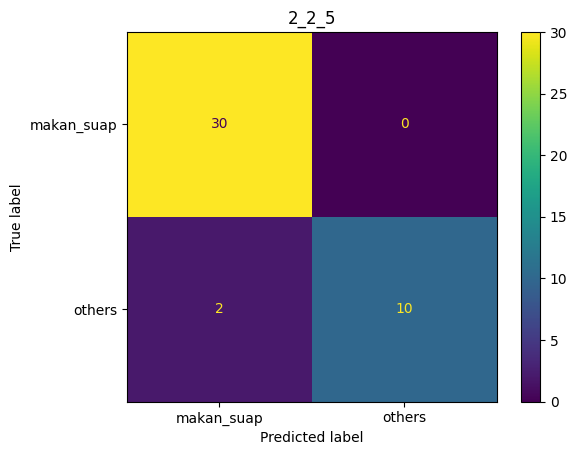

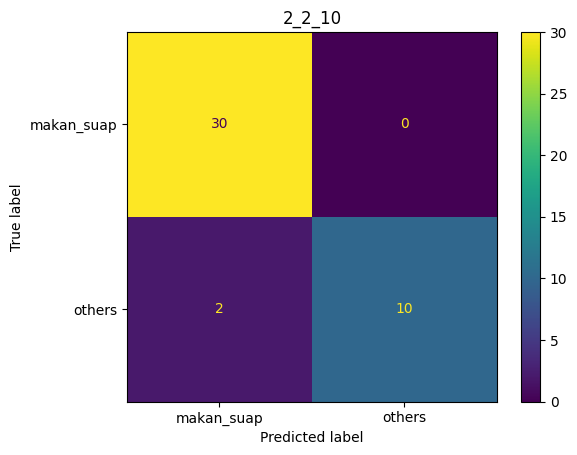

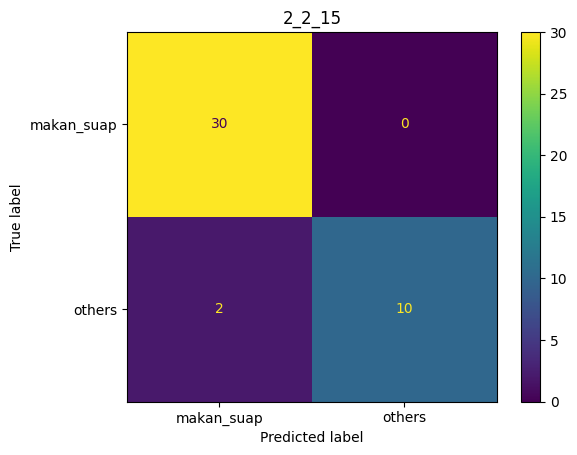

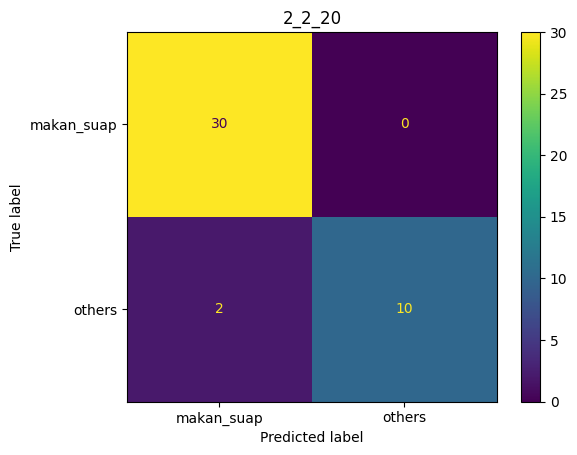

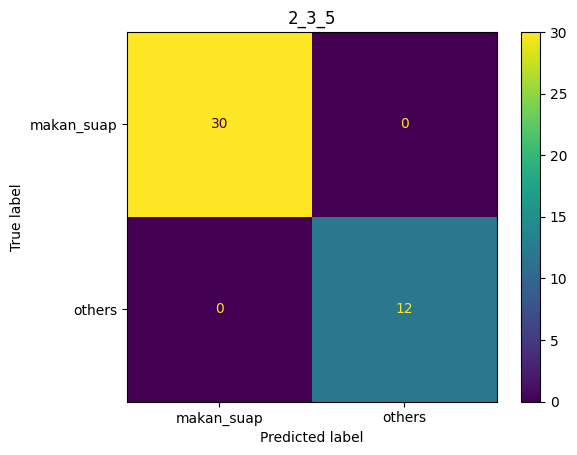

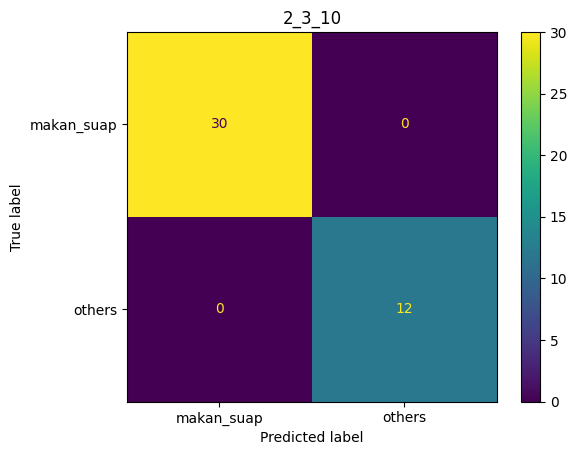

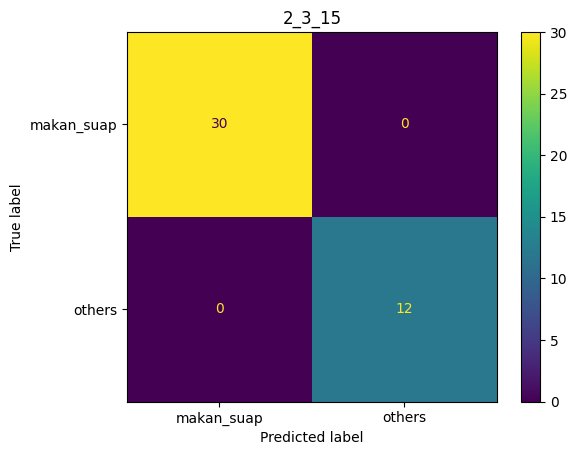

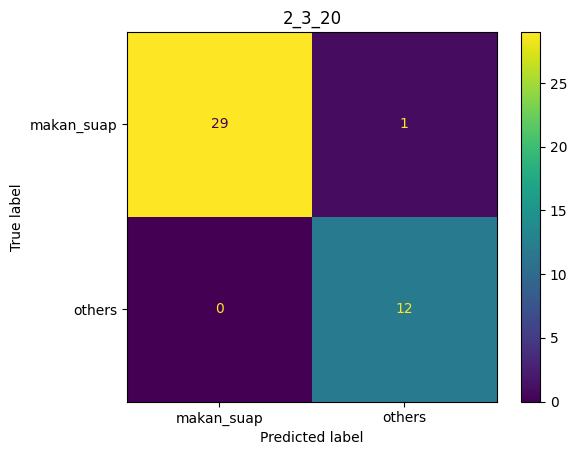

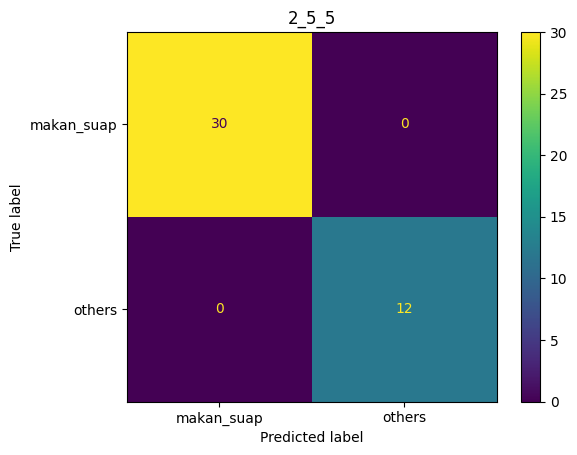

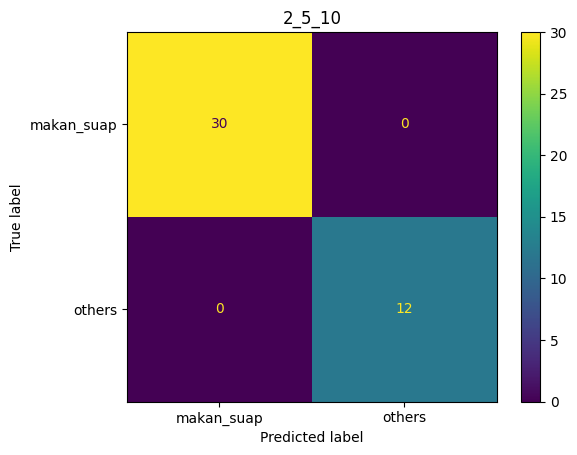

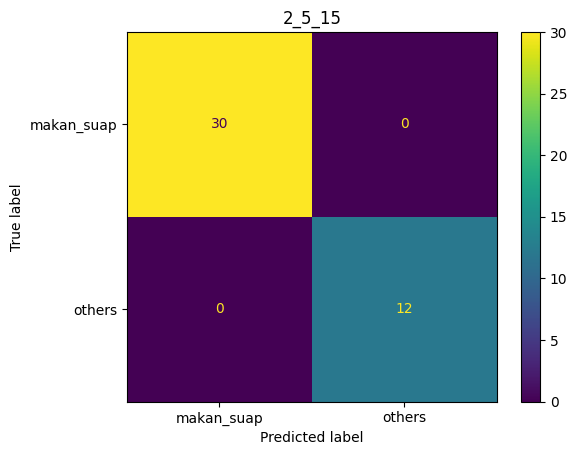

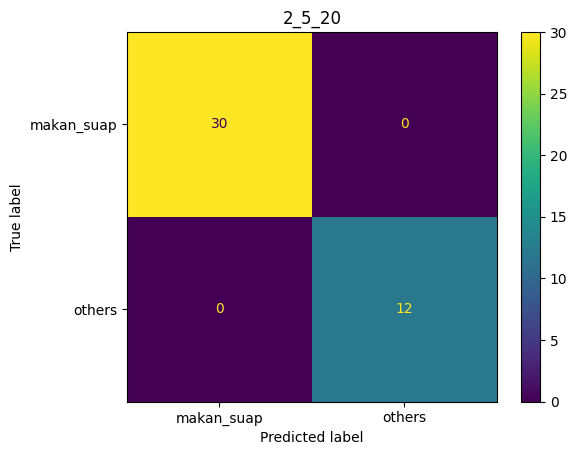

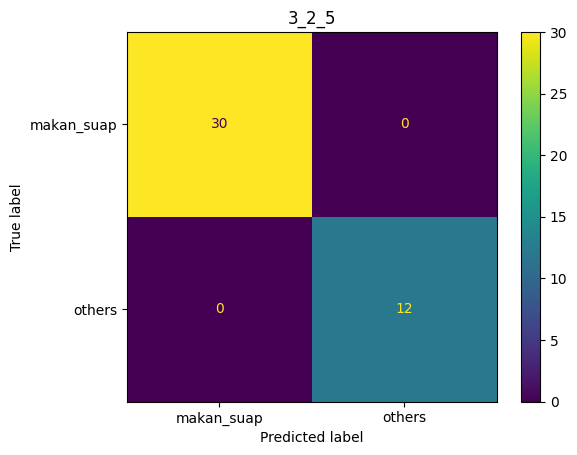

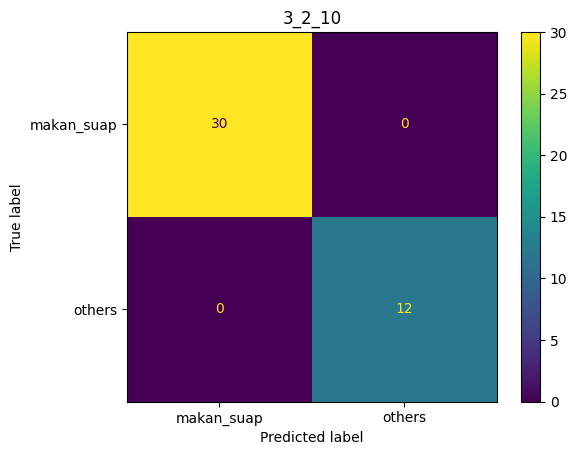

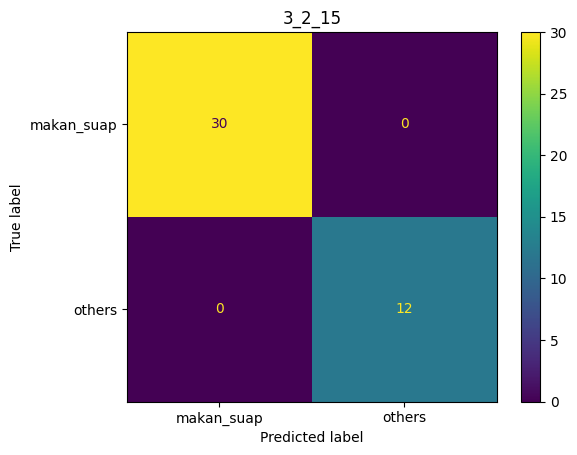

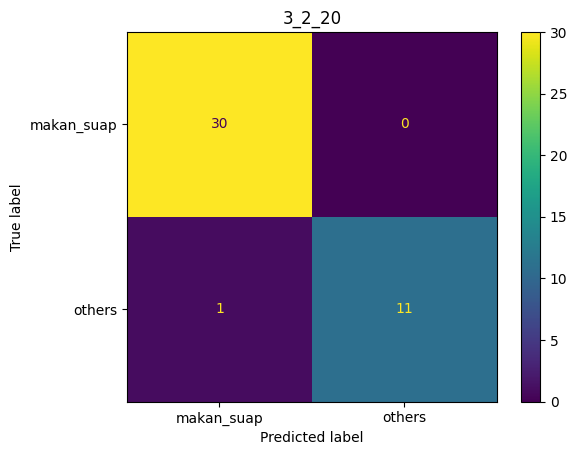

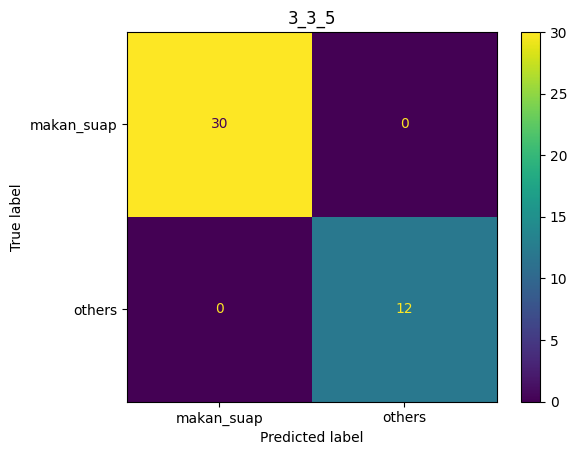

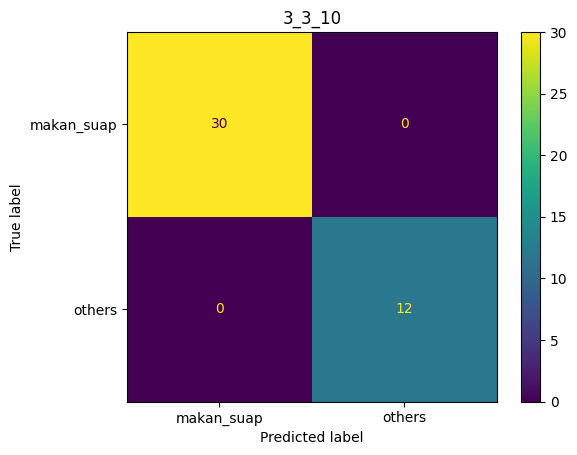

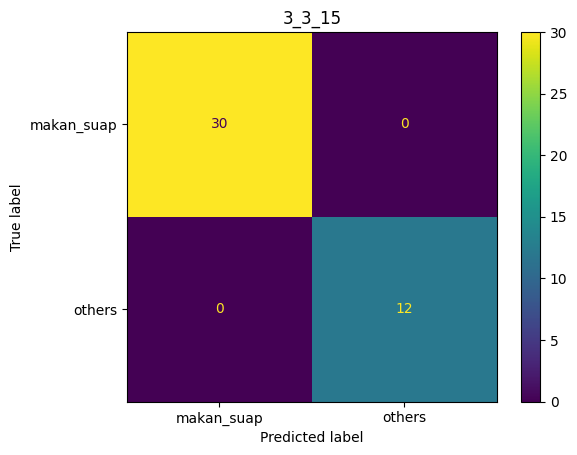

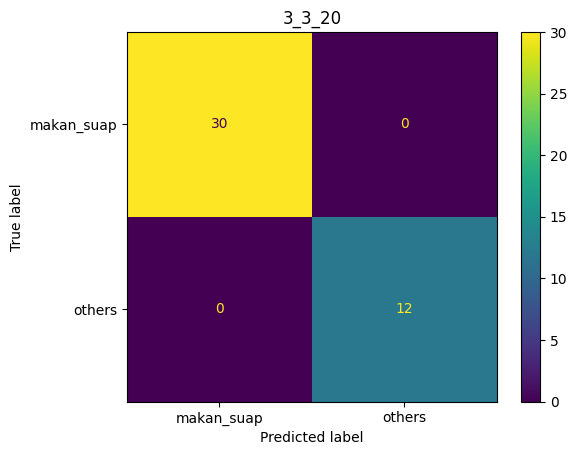

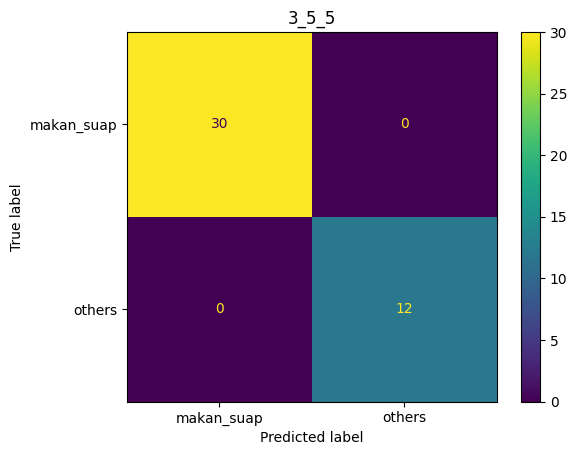

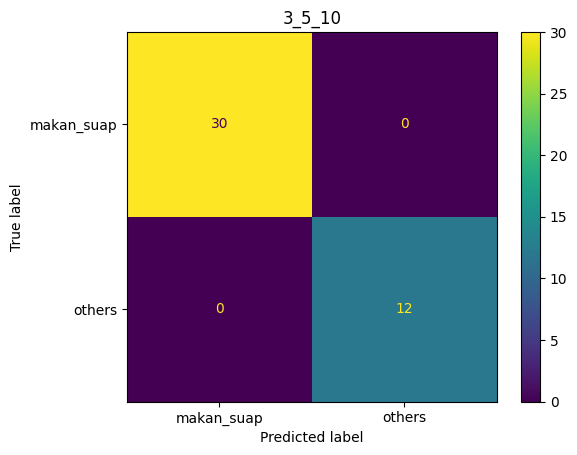

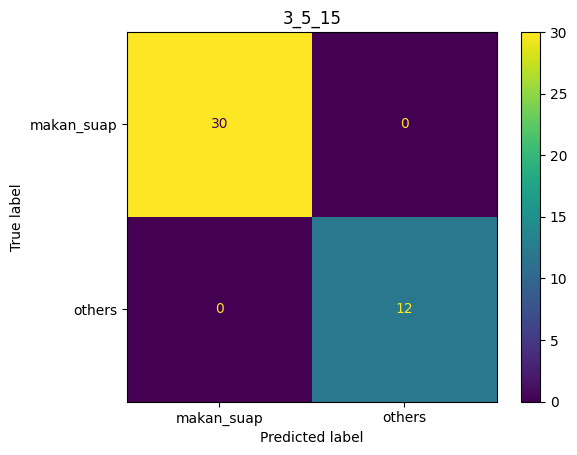

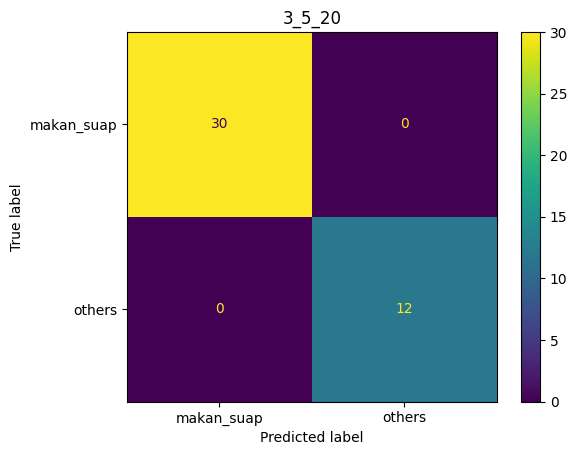

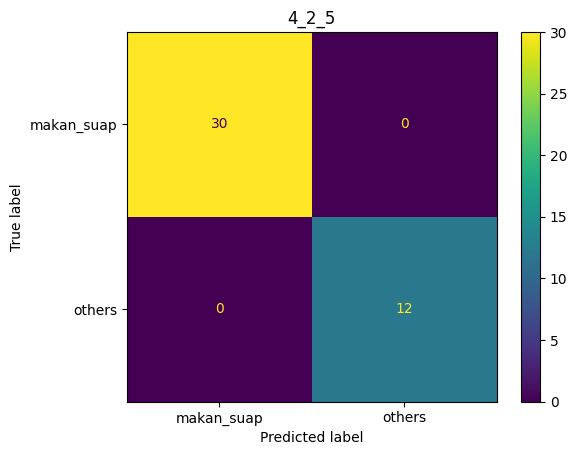

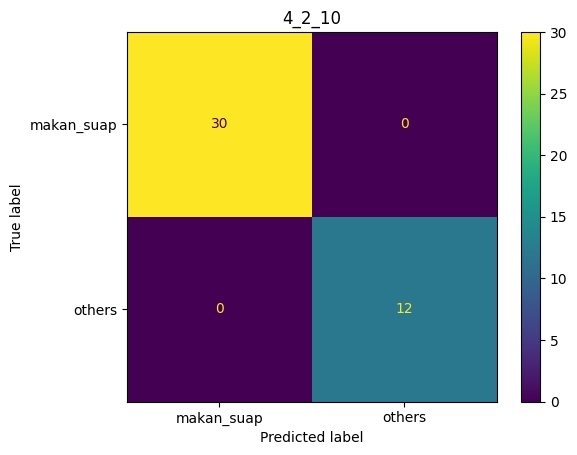

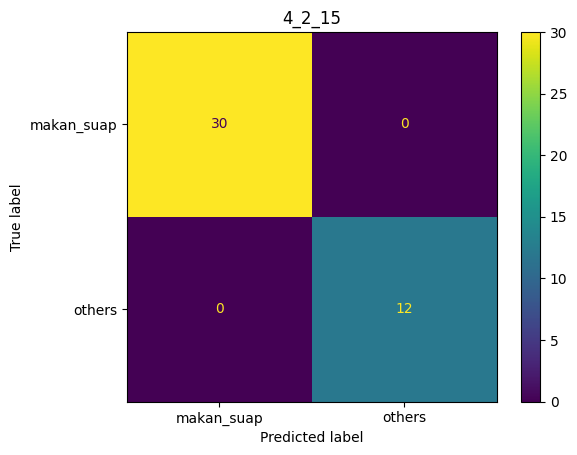

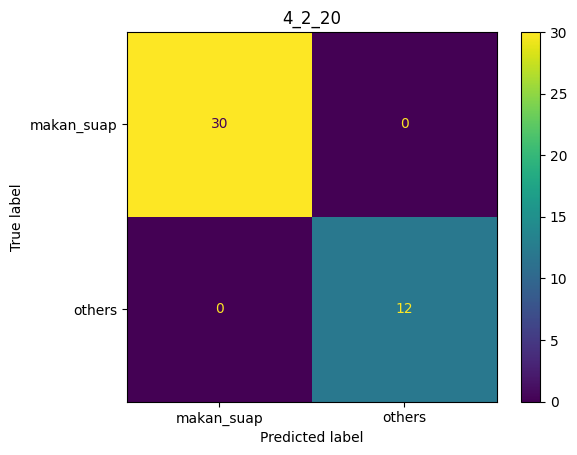

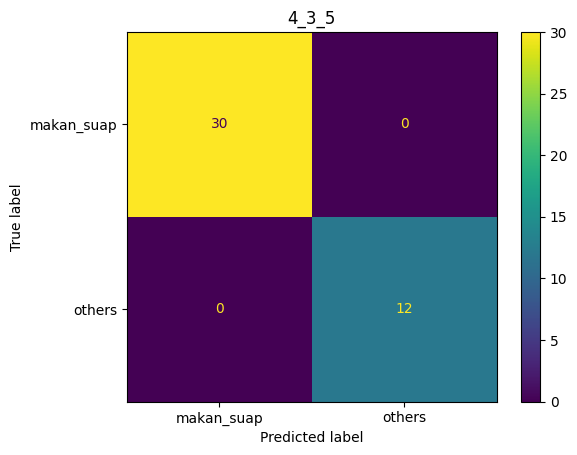

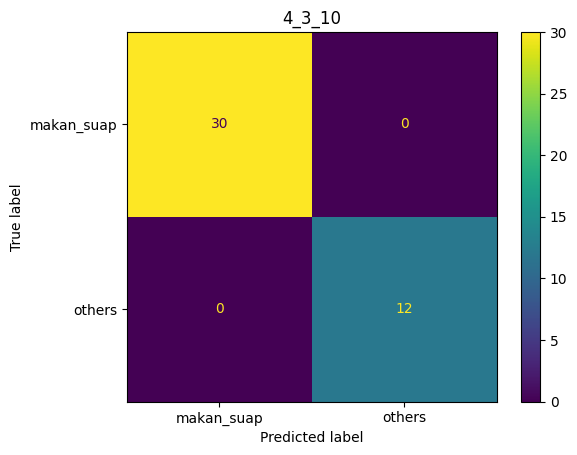

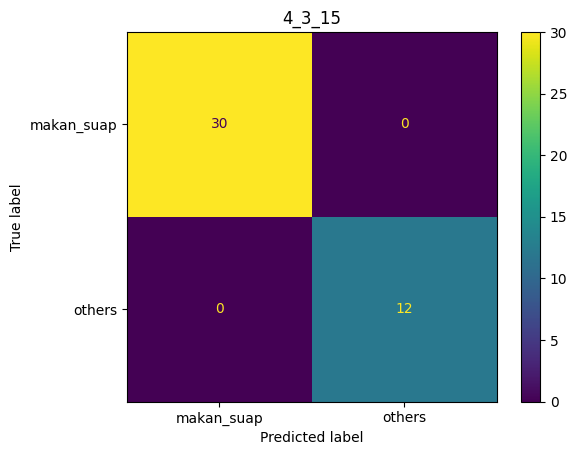

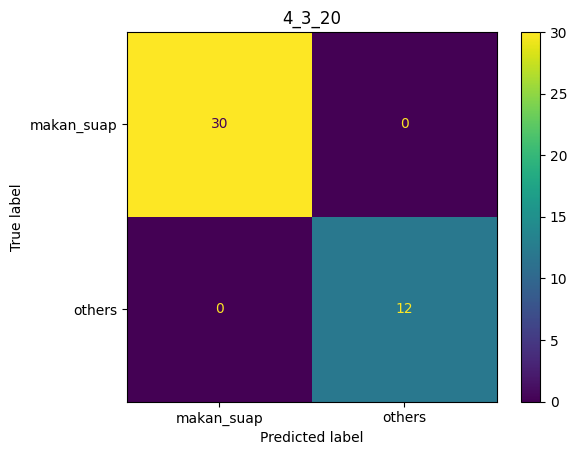

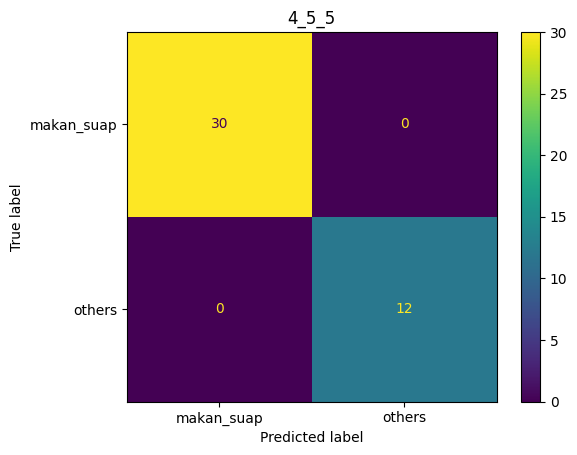

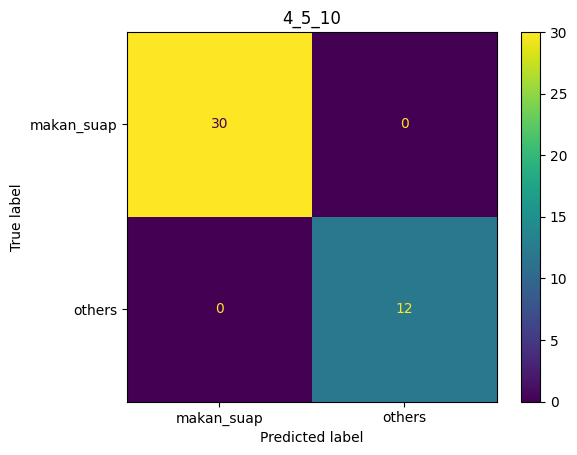

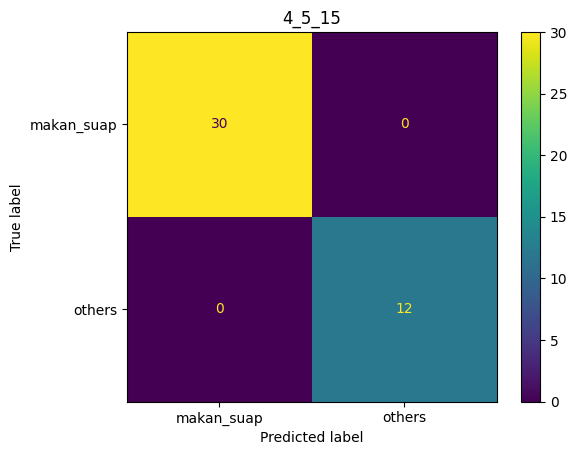

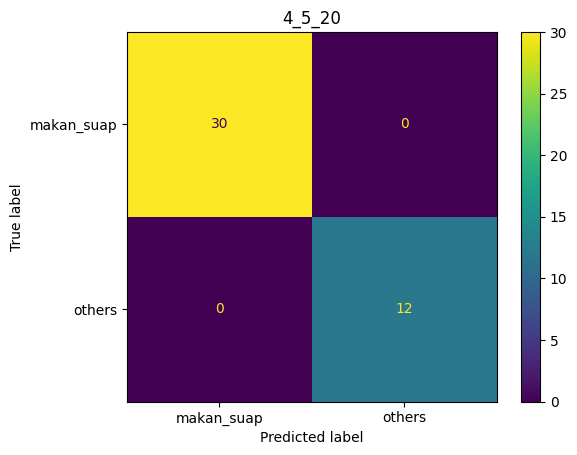

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = sorted(testing['label'].unique())

for model in models:
    cm = confusion_matrix(testing['label'], testing[model], labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot()
    disp.ax_.set_title(model)

In [13]:
from sklearn.metrics import classification_report
# https://pastebin.com/283FEmrc

for selected in models:
    print(selected)
    print(classification_report(testing['label'], testing[selected], target_names=labels))

2_2_5
              precision    recall  f1-score   support

  makan_suap       0.94      1.00      0.97        30
      others       1.00      0.83      0.91        12

    accuracy                           0.95        42
   macro avg       0.97      0.92      0.94        42
weighted avg       0.96      0.95      0.95        42

2_2_10
              precision    recall  f1-score   support

  makan_suap       0.94      1.00      0.97        30
      others       1.00      0.83      0.91        12

    accuracy                           0.95        42
   macro avg       0.97      0.92      0.94        42
weighted avg       0.96      0.95      0.95        42

2_2_15
              precision    recall  f1-score   support

  makan_suap       0.94      1.00      0.97        30
      others       1.00      0.83      0.91        12

    accuracy                           0.95        42
   macro avg       0.97      0.92      0.94        42
weighted avg       0.96      0.95      0.95        42


In [14]:
df_test = get_audio_path_and_label('./testing/', selected_data)
df_test

,path,label
0,./testing/makan_suap/Nested Sequence 01.wav,makan_suap
1,./testing/makan_suap/Nested Sequence 02.wav,makan_suap
2,./testing/makan_suap/Nested Sequence 03.wav,makan_suap
3,./testing/makan_suap/Nested Sequence 04.wav,makan_suap
4,./testing/makan_suap/Nested Sequence 05.wav,makan_suap
5,./testing/makan_suap/Nested Sequence 06.wav,makan_suap
6,./testing/makan_suap/Nested Sequence 07.wav,makan_suap
7,./testing/makan_suap/Nested Sequence 08.wav,makan_suap
8,./testing/makan_suap/Nested Sequence 09.wav,makan_suap
9,./testing/makan_suap/Nested Sequence 10.wav,makan_suap


In [15]:
# Normalize volume on each audio
from pydub import AudioSegment, effects

for index, row in df_test.iterrows():
    rawsound = AudioSegment.from_file(row['path'], "wav")  
    normalizedsound = effects.normalize(rawsound)
    normalizedsound.export("./testing/" + row['label'] + "/" + row['path'].split('/')[-1], format="wav")

In [16]:
X = np.array(extract_features(["testing/suap/Nested Sequence 30.wav"], True))

correct_models = []

for model in models:
    scores = {}

    for label in models[model]:
        score = models[model][label].score(X)
        scores[label] = score

    maxxed = max(zip(scores.values(), scores.keys()))

    if maxxed[1] != "others":
        correct_models.append(model)

print(correct_models)

['2_2_5', '2_2_10', '2_2_15', '2_2_20', '2_3_20', '2_5_5', '3_2_5', '3_2_10', '3_2_15', '3_2_20', '3_3_5', '3_3_10', '3_3_15', '3_3_20', '3_5_5', '3_5_10', '3_5_15', '3_5_20', '4_3_5', '4_3_10', '4_3_15', '4_3_20', '4_5_5', '4_5_10', '4_5_15', '4_5_20']


In [17]:
for model in models:
    df_test[model] = df_test['path'].apply(lambda x: predict(x, models[model], True))

In [18]:
df_test.to_csv("result.csv")

In [19]:
from sklearn.metrics import classification_report

for selected in models:
    print(selected)
    print(classification_report(df_test['label'], df_test[selected], target_names=labels))

2_2_5
              precision    recall  f1-score   support

  makan_suap       0.70      0.93      0.80        30
      others       0.33      0.08      0.12        13

    accuracy                           0.67        43
   macro avg       0.52      0.51      0.46        43
weighted avg       0.59      0.67      0.60        43

2_2_10
              precision    recall  f1-score   support

  makan_suap       0.70      0.93      0.80        30
      others       0.33      0.08      0.12        13

    accuracy                           0.67        43
   macro avg       0.52      0.51      0.46        43
weighted avg       0.59      0.67      0.60        43

2_2_15
              precision    recall  f1-score   support

  makan_suap       0.71      0.97      0.82        30
      others       0.50      0.08      0.13        13

    accuracy                           0.70        43
   macro avg       0.60      0.52      0.48        43
weighted avg       0.64      0.70      0.61        43


C:\Users\lazy1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lazy1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lazy1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

In [25]:
# Dump model into pickle
import pickle
from datetime import date

# Today date in Ymd format
today = date.today().strftime("%Y%m%d")

for model in models:
    for label in models[model]:
        name = f"{model}_{label}"

        with open(f"models/{today}/{name}.pkl", "wb") as file: 
            pickle.dump(models[model][label], file)

In [24]:
import speech_recognition as sr

r = sr.Recognizer()
mic = sr.Microphone(device_index=1)
mic.SAMPLE_RATE = 48000

detected = False
stop_listening = None

with mic as source:
    print("Calibrating...")
    r.adjust_for_ambient_noise(source)
    print("Calibrated!")

Calibrating...
Calibrated!


In [21]:
import time
from speech_recognition import AudioData

def callback(recognizer, audio: AudioData):
    global stop_listening, detected

    print("Detected something...")

    # Dump audio into .wav file
    with open(f"coba.wav", "wb") as f:
        f.write(audio.get_wav_data())

    features = extract_features([f"coba.wav"], True)

    for model in models:
        scores = {}

        for label in models[model]:
            score = models[model][label].score(features)
            scores[label] = score

        print(model, max(zip(scores.values(), scores.keys())), scores)

    detected = True
    stop_listening(wait_for_stop=False)


def wait_till_asked_to_continue():
    global stop_listening, detected

    detected = False

    print("Listening...")
    stop_listening = r.listen_in_background(mic, callback, phrase_time_limit=1)

    while not detected:
        time.sleep(0.1)

In [44]:
wait_till_asked_to_continue()

Listening...
Detected something...
2_2_5 (-10364.207123351716, 'others') {'makan_suap': -10670.231578751387, 'others': -10364.207123351716}
2_2_10 (-10388.02457343017, 'others') {'makan_suap': -10658.672241415386, 'others': -10388.02457343017}
2_2_15 (-10388.30249834377, 'others') {'makan_suap': -10647.77410795908, 'others': -10388.30249834377}
2_2_20 (-10388.30249834377, 'others') {'makan_suap': -10645.487440850773, 'others': -10388.30249834377}
2_3_5 (-9759.993111347341, 'others') {'makan_suap': -11467.268235230596, 'others': -9759.993111347341}
2_3_10 (-9740.05393792, 'others') {'makan_suap': -11431.82735443415, 'others': -9740.05393792}
2_3_15 (-9702.418232404472, 'others') {'makan_suap': -11412.427390338891, 'others': -9702.418232404472}
2_3_20 (-9713.586159605344, 'others') {'makan_suap': -11409.77242855852, 'others': -9713.586159605344}
2_5_5 (-10156.663747592273, 'others') {'makan_suap': -11503.297529343381, 'others': -10156.663747592273}
2_5_10 (-9769.01756941322, 'others') {'